In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-d3ztp0na
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-d3ztp0na
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [5]:
%load_ext nvcc_plugin

directory /notebooks/src already exists
Out bin /notebooks/result.out


In [6]:
%%cu
#include <algorithm>
#include <cstdlib>
#include <chrono>
#include <cassert>
#include <iostream>
#include <string> // to_string

using namespace std;
using namespace std::chrono;

float* address_mat1 = NULL;
float* address_mat2 = NULL;
float* address_matFinal = NULL;

void init_matrix(float* mat, int h, int w) {
    for (int i = 0; i < h * w; i++) {
        mat[i] = rand() % 100 / 2.0f;
    }
}

float cpu_matmul(const float* mat1, const float* mat2, float* finalMat, const int h1, const int w1, const int w2) {  
	for (int i = 0; i < h1; i++) {
		for (int j = 0;j < w2; j++) {
			for (int k = 0; k < w1; k++) {
				finalMat[i * h1 + j] += mat1[i * h1 + k] * mat2[k * w1 + j];
			}
		}
	}
}

__global__ void matrixMul(const float* a, const float* b, float* c, int h1, int w1, int w2) {

	int row = blockIdx.y * blockDim.y + threadIdx.y;
	int col = blockIdx.x * blockDim.x + threadIdx.x;

	if (row < h1 && col < w2) {
		float accum = 0.0f;
		for (int i = 0; i < w1; i++) {
			accum += a[row * h1 + i] * b[i * w1 + col];
		}
		c[row * h1 + col] = accum;
	}
}

float gpu_matmul(const float* mat1, const float* mat2, float* finalMat, const int h1, const int w1, const int w2, const int threads_x, const int threads_y) {

    // Allocate memory in cuda device memory
	cudaMalloc(&address_mat1,     h1 * w1 * sizeof(float));
	cudaMalloc(&address_mat2,     w1 * w2 * sizeof(float));
	cudaMalloc(&address_matFinal, h1 * w2 * sizeof(float));

    // Transfer the data to the device
    size_t size_mat1 =      h1 * w1 * sizeof(float);
    size_t size_mat2 =      w1 * w2 * sizeof(float);
    size_t size_mat_final = h1 * w2 * sizeof(float);
    
    // Copy matrix from host memory to device memory
    cudaMemcpy(address_mat1, mat1, size_mat1, cudaMemcpyHostToDevice); 
    cudaMemcpy(address_mat2, mat2, size_mat2, cudaMemcpyHostToDevice);

	// Kernel params
	dim3 THREADS(threads_x, threads_y);
	dim3 BLOCKS((h1 + THREADS.x - 1) / THREADS.x, (w2 + THREADS.y - 1) / THREADS.y);

	matrixMul<<<BLOCKS, THREADS>>>(address_mat1, address_mat2, address_matFinal, h1, w1, w2);
    
    // Waiting for all threads ade done
	cudaDeviceSynchronize();
    
    // Transfer the data to the host
    cudaMemcpy(finalMat, address_matFinal, size_mat_final, cudaMemcpyDeviceToHost);
    
    // Dispose CUDA memory
    cudaFree(address_mat1);
	cudaFree(address_mat2);
	cudaFree(address_matFinal);
}


void check_result(const float* mat1, const float* mat2, const int h1, const int w1) {   
    for (int i = 0; i < h1 * w1; i++) {
        assert(mat1[i] == mat2[i]);
    }
}

float getCPUDuration(const float* mat1, const float* mat2, float* finalMat, const int h1, const int w1, const int w2) {
    auto startCPU = high_resolution_clock::now();
    cpu_matmul(mat1, mat2, finalMat, h1, w1, w2);
    auto stopCPU = high_resolution_clock::now();
    auto durationCPU = duration_cast<milliseconds>(stopCPU - startCPU);
    return durationCPU.count();
}

float getGPUDuration(const float* mat1, const float* mat2, float* finalMat, const int h1, const int w1, const int w2) {
    auto startGPU = high_resolution_clock::now();
    gpu_matmul(mat1, mat2, finalMat, h1, w1, w2, 16, 32);
    auto stopGPU = high_resolution_clock::now();
    auto durationGPU = duration_cast<milliseconds>(stopGPU - startGPU);
    return durationGPU.count();
}

int main() {
    
    int h1 = 10, w1 = 10, h2 = 10, w2 = 10;
    while (h1 < 1000) {
        h1 = h1 + 1000;
        w1 = w1 + 1000;
        h2 = h2 + 1000;
        w2 = w2 + 1000;
        
        float* mat1 = (float*)malloc(h1 * w1 * sizeof(float));
        float* mat2 = (float*)malloc(h2 * w2 * sizeof(float));
        float* mat_finalCPU = (float*)malloc(h1 * w2 * sizeof(float));
        float* mat_finalGPU = (float*)malloc(h1 * w2 * sizeof(float));
    
        init_matrix(mat1, h1, w1);
        init_matrix(mat2, h2, w2);

        cout << "Matrix size - " << h1 << "x" << w1 << " and " << h2 << "x" << w2 << endl;
    
        cout << "Time taken by CPU function: " 
             << getCPUDuration(mat1, mat2, mat_finalCPU, h1, w1, w2) << " milliseconds" << endl;
 
        cout << "Time taken by GPU function: " 
             << getGPUDuration(mat1, mat2, mat_finalGPU, h1, w1, w2) << " milliseconds" << endl;

        check_result(mat_finalCPU, mat_finalGPU, h1, w2);
        
        free(mat1);
        free(mat2);
        free(mat_finalCPU);
        free(mat_finalGPU);
    }
    return 0; 
}

Matrix size - 1010x1010 and 1010x1010
Time taken by CPU function: 13792 milliseconds
Time taken by GPU function: 186 milliseconds



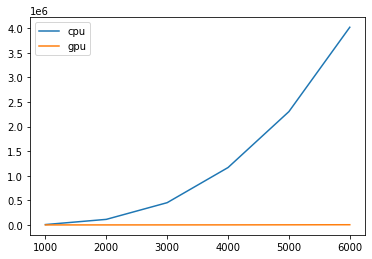

In [7]:
import matplotlib.pyplot as plt

cpu = [7267, 112964, 452297, 1166480, 2303390, 4018320]
gpu = [193, 161, 494, 1171, 2262, 4024]
size = [1000, 2000, 3000, 4000, 5000, 6000]

fig, ax = plt.subplots()
ax.plot(size, cpu, label="cpu")
ax.plot(size, gpu, label="gpu")
ax.legend()

plt.show()